# Project1 Classification Analysis on Textual Data

## Problem A

Load Files

In [1]:
from sklearn.datasets import fetch_20newsgroups
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']
train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

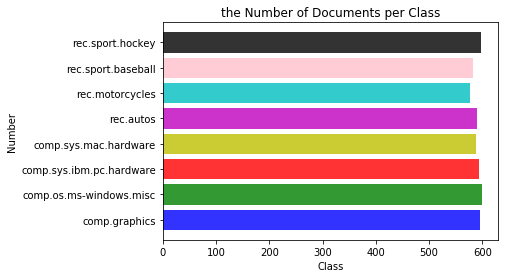

In [2]:
import matplotlib.pyplot as plt

value = {}
for i in train.target:
    if i not in value:
        value[i] = 0
    else:
        value[i] += 1
fig = plt.figure()
ax = fig.add_subplot(111)
colors = ['b','g','r','y','m','c','pink','k']
plt.barh(train.target_names, list(value.values()),alpha=0.8, color=colors)
plt.xlabel('Class')
plt.ylabel('Number')
plt.title('the Number of Documents per Class')
plt.show()

## Problem B

First tokenize each document into words.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(min_df=1)
train_counts = count_vectorizer.fit_transform(train.data)
train_counts.shape

(4732, 79218)

Then, excluding the stop words, punctuations, and using stemmed version of words, create a TFxIDF vector representations.

In [4]:
from sklearn.feature_extraction import text
from nltk.stem.snowball import SnowballStemmer
import string,re

def stemming_tokenizer(text):
    stemmer = SnowballStemmer("english")
    text = "".join([a for a in text if a not in string.punctuation]) # remove all punctuation
    text = re.sub('[,.-:/()?{}*$#&]',' ', text) # remove all symbols
    text = "".join(b for b in text if ord(b) < 128) # remove all non-ascii characters
    words = text.split()
    stemmed = [stemmer.stem(item) for item in words]
    return stemmed

stop_words = text.ENGLISH_STOP_WORDS

count_vect_final = CountVectorizer(analyzer='word' , tokenizer=stemming_tokenizer, stop_words=stop_words, min_df=4, max_df =0.99)
train_counts_final = count_vect_final.fit_transform(train.data)

count_vect_2 = CountVectorizer(analyzer='word' , tokenizer=stemming_tokenizer, stop_words=stop_words, min_df=2, max_df =0.99)
train_counts_2 = count_vect_2.fit_transform(train.data)

count_vect_5 = CountVectorizer(analyzer='word' , tokenizer=stemming_tokenizer, stop_words=stop_words, min_df=5, max_df =0.99)
train_counts_5 = count_vect_5.fit_transform(train.data)

print ("Number of terms Extracted : " + str(train_counts_final.shape[1]))
print ("Number of terms Extracted if mid_df=2: " + str(train_counts_2.shape[1]))
print ("Number of terms Extracted if mid_df=5: " + str(train_counts_5.shape[1]))

Number of terms Extracted : 10741
Number of terms Extracted if mid_df=2: 21793
Number of terms Extracted if mid_df=5: 8816


TFxIDF

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_train = tfidf_transformer.fit_transform(train_counts_final)
tfidf_train.shape

(4732, 10741)

In [6]:
train_counts_final.shape

(4732, 10741)

## Problem C

Find the 10 most significant terms in each of the following classes with respect to TFxICF measure.

TF -- the term frequency in a class

In [7]:
all_categories = ['comp.graphics',
                'comp.os.ms-windows.misc',
                'comp.sys.ibm.pc.hardware',
                'comp.sys.mac.hardware',
                'comp.windows.x',
                'rec.autos',
                'rec.motorcycles',
                'rec.sport.baseball',
                'rec.sport.hockey',
                'alt.atheism',
                'sci.crypt',
                'sci.electronics',
                'sci.med',
                'sci.space',
                'soc.religion.christian',
                'misc.forsale',
                'talk.politics.guns',
                'talk.politics.mideast',
                'talk.politics.misc',
                'talk.religion.misc'
                ]

all_docs_per_category = []
for cate in all_categories:
    category_data = fetch_20newsgroups(subset='train',categories=[cate]).data
    temp = ""
    for doc in category_data:
        temp = temp + " "+ doc
    all_docs_per_category.append(temp)
    
vectorizer = CountVectorizer(analyzer='word',stop_words=stop_words, tokenizer=stemming_tokenizer, min_df=4)
vectorized_newsgroups_train = vectorizer.fit_transform(all_docs_per_category)
vectorized_newsgroups_train.shape

(20, 10714)

Calculate the TFxICF

In [8]:
tfidf_class_transformer = TfidfTransformer()
tficf_train = tfidf_class_transformer.fit_transform(vectorized_newsgroups_train)

Find the 10 most significant terms

In [9]:
import numpy as np

tficf_train_copy = tficf_train.copy()
features = vectorizer.get_feature_names()
for i in [2, 3, 14, 15]:
    temp = []
    for j in range(10):
        temp.append(features[np.argmax(tficf_train_copy[i])])
        tficf_train_copy[i, np.argmax(tficf_train_copy[i])] = 0
    print(all_categories[i],temp)

comp.sys.ibm.pc.hardware ['scsi', 'drive', 'ide', 'use', 'line', 'subject', 'organ', 'card', 'control', 'mb']
comp.sys.mac.hardware ['line', 'mac', 'subject', 'organ', 'use', 'simm', 'appl', 'scsi', 'problem', 'drive']
soc.religion.christian ['god', 'christian', 'jesus', 'church', 'subject', 'peopl', 'line', 'say', 'christ', 'believ']
misc.forsale ['line', 'subject', 'sale', 'organ', 'univers', 'new', 'use', 'offer', 'dos', 'nntppostinghost']


## Problem D

Apply **LSI** to TFxIDF matrix corresponding to the 8 classes, and pick k=50.

In [10]:
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=50, random_state=42)
transformed_tfidf = SVD.fit_transform(tfidf_train)
print("Dimensions of TF-IDF vector after LSI: "+ str(transformed_tfidf.shape))

Dimensions of TF-IDF vector after LSI: (4732, 50)


Alternatively, reduce dimensionality through Non-Negeative Matrix Factorization(**NMF**), and pick k=50.

In [11]:
from sklearn.decomposition import NMF

trainNMF = NMF(n_components=50, init='random', random_state=42)
NMFed_train = trainNMF.fit_transform(tfidf_train)
NMFed_train.shape

(4732, 50)

## Problem E

### Use hard margin SVM classifer (SVC) to separate the documents into 'Computer Technology' vs 'Recreational Activity' groups.

Build a hard margin SVM classifier(SVC)

In [12]:
from sklearn import svm
hard_classifier = svm.LinearSVC(C=1000 ,dual=False, random_state=42) 
train_targets = [1 if t > 3 else 0 for t in train.target]
        
hard_classifier.fit(transformed_tfidf, train_targets)#train the classifier

LinearSVC(C=1000, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

Preparing the test data

In [13]:
test = fetch_20newsgroups(subset="test", categories=categories, shuffle=True, random_state=42)
test_counts = count_vect_final.transform(test.data)
tfidf_test = tfidf_transformer.transform(test_counts)
transformed_test_tfidf = SVD.transform(tfidf_test)
test_targets = [1 if t > 3 else 0 for t in test.target]

Predict the test data

In [14]:
predicted = hard_classifier.predict(transformed_test_tfidf)

plot the ROC curve, report the confusion matrix and calculate the accuracy, recall and precision of classifier.

Accuracy of Hard Margin SVM: 0.974920634921
------------------------------------------------------------
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.98      0.97      0.97      1560
Recreational activity       0.97      0.98      0.98      1590

          avg / total       0.98      0.97      0.97      3150

------------------------------------------------------------
Confusion Matrix: 
[[1508   52]
 [  27 1563]]
------------------------------------------------------------


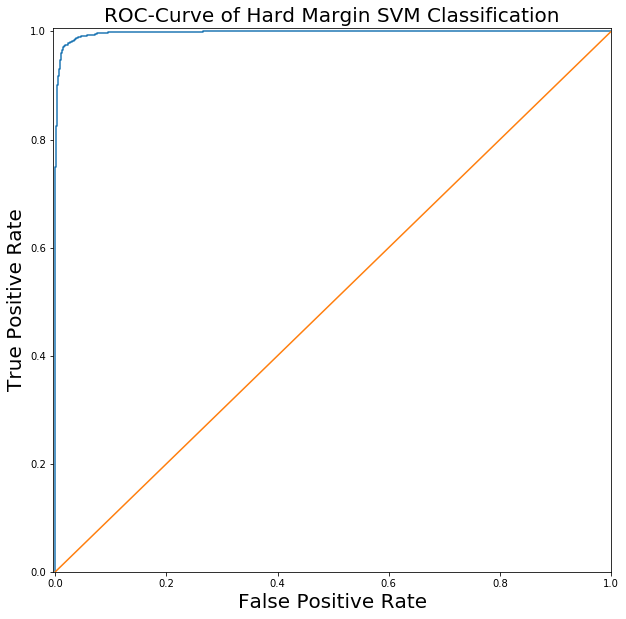

In [15]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

score = hard_classifier.decision_function(transformed_test_tfidf)
accuracy = np.mean(predicted == test_targets)
# Report results
print("Accuracy of Hard Margin SVM: " + str(accuracy))
print("-"*60)
print("Classification report: ")
print(classification_report(test_targets, predicted, target_names=['Computer technology', 'Recreational activity']))
print("-"*60)
print("Confusion Matrix: ")
print(confusion_matrix(test_targets, predicted))
print("-"*60)

fpr, tpr, threshold = roc_curve(test_targets, score)
line = [0, 1]
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 20)
plt.title('ROC-Curve of Hard Margin SVM Classification', fontsize = 20)
plt.axis([-0.004, 1, 0, 1.006])
plt.show()

### Use soft margin SVM classifer to separate the documents into 'Computer Technology' vs 'Recreational Activity' groups.

In [16]:
soft_classifier = svm.LinearSVC( C=0.001 ,dual=False, random_state=42)
soft_classifier.fit(transformed_tfidf, train_targets)

LinearSVC(C=0.001, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

Accuracy of soft margin Linear SVM: 0.942857142857
------------------------------------------------------------
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.99      0.89      0.94      1560
Recreational activity       0.90      0.99      0.95      1590

          avg / total       0.95      0.94      0.94      3150

------------------------------------------------------------
Confusion Matrix: 
[[1392  168]
 [  12 1578]]
------------------------------------------------------------


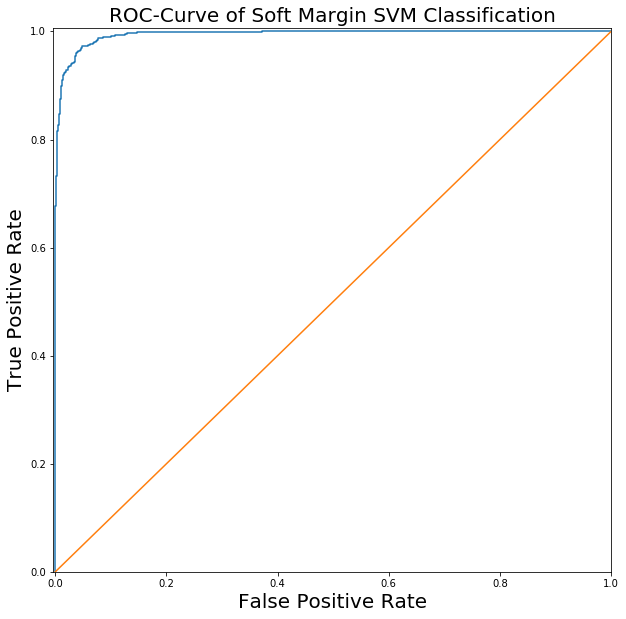

In [17]:
predicted_soft = soft_classifier.predict(transformed_test_tfidf)
score_soft = soft_classifier.decision_function(transformed_test_tfidf)
accuracy_soft = np.mean(predicted_soft == test_targets)
# Report results
print("Accuracy of soft margin Linear SVM: " + str(accuracy_soft))
print("-"*60)
print("Classification report: ")
print(classification_report(test_targets, predicted_soft, target_names=['Computer technology', 'Recreational activity']))
print("-"*60)
print("Confusion Matrix: ")
print(confusion_matrix(test_targets, predicted_soft))
print("-"*60)

fpr_soft, tpr_soft, threshold_soft = roc_curve(test_targets, score_soft)
line = [0, 1]
plt.figure(figsize=(10,10))
plt.plot(fpr_soft, tpr_soft)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 20)
plt.title('ROC-Curve of Soft Margin SVM Classification', fontsize = 20)
plt.axis([-0.004, 1, 0, 1.006])
plt.show()

###  Alternatively，classify documents using NMF to reduce dimensionality  

Passing：May be completed later

## Problem F

Using a 5-fold cross_validation, find the best value of the parameter $ \gamma $ in the range  $ \left \{ 10^k \mid -3 \leq k \leq 3, k \in Z \right \} $

In [18]:
from sklearn.model_selection import cross_val_score

best_score = 0
best_gamma = 0
for gamma_value in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    classifier = svm.LinearSVC(C=gamma_value, dual=False, random_state=42)
    classifier.fit(transformed_tfidf, train_targets)
    scores = (cross_val_score(classifier, transformed_tfidf, train_targets, cv=5))
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_gamma = gamma_value
    
    print("Accuracy: %0.8f (+/- %0.8f)" % (scores.mean(), scores.std() * 2)) # But I really don't know what is the best gamma stand for...

print("Best Accuracy is %0.8f obtained for gamma = " % best_score + str(best_gamma))      

Accuracy: 0.94674847 (+/- 0.00886187)
Accuracy: 0.96619121 (+/- 0.01106256)
Accuracy: 0.96999537 (+/- 0.01415634)
Accuracy: 0.97591079 (+/- 0.00815218)
Accuracy: 0.97675623 (+/- 0.00692097)
Accuracy: 0.97612198 (+/- 0.00687109)
Accuracy: 0.97633340 (+/- 0.00817760)
Best Accuracy is 0.97675623 obtained for gamma = 10


Accuracy of Linear SVM using gamma=10 : 0.975238095238
------------------------------------------------------------
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.98      0.97      0.97      1560
Recreational activity       0.97      0.98      0.98      1590

          avg / total       0.98      0.98      0.98      3150

------------------------------------------------------------
Confusion Matrix: 
[[1509   51]
 [  27 1563]]
------------------------------------------------------------


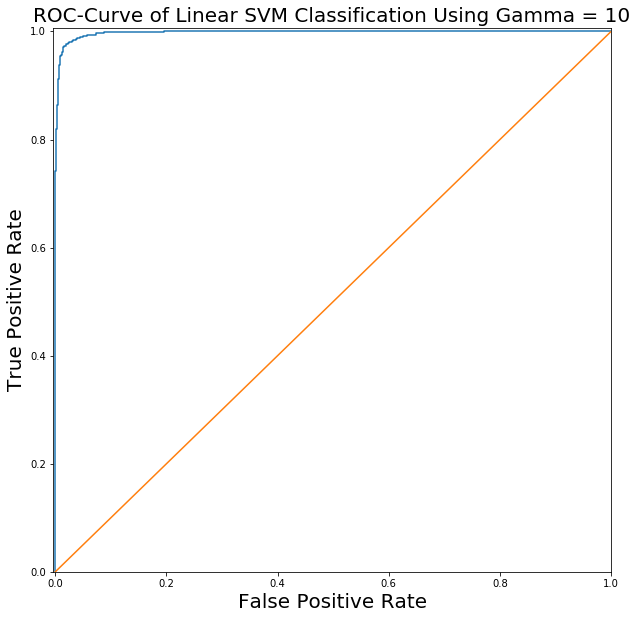

In [19]:
bestclassifier = svm.LinearSVC(C=best_gamma, dual=False, random_state=42)
bestclassifier.fit(transformed_tfidf, train_targets)
prediction = bestclassifier.predict(transformed_test_tfidf)
onescore = bestclassifier.decision_function(transformed_test_tfidf)
oneaccuracy = np.mean(prediction == test_targets)
# Report results
print("Accuracy of Linear SVM using gamma=%s : " % best_gamma + str(oneaccuracy))
print("-"*60)
print("Classification report: ")
print(classification_report(test_targets, prediction, target_names=['Computer technology', 'Recreational activity']))
print("-"*60)
print("Confusion Matrix: ")
print(confusion_matrix(test_targets, prediction))
print("-"*60)

onefpr, onetpr, onethreshold = roc_curve(test_targets, onescore)
line = [0, 1]
plt.figure(figsize=(10,10))
plt.plot(onefpr, onetpr)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 20)
plt.title('ROC-Curve of Linear SVM Classification Using Gamma = '+ str(best_gamma), fontsize = 20)
plt.axis([-0.004, 1, 0, 1.006])
plt.show()


## Problem G

Using Naïve Bayes algorithm for the same classification task

Train a multinomial naïve Bayes classifier and plot the ROC curve for different values of the threshold on
class probabilities. 

Accuracy of multinomial naïve Bayes: 0.898412698413
------------------------------------------------------------
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       1.00      0.80      0.89      1560
Recreational activity       0.83      1.00      0.91      1590

          avg / total       0.91      0.90      0.90      3150

------------------------------------------------------------
Confusion Matrix: 
[[1244  316]
 [   4 1586]]
------------------------------------------------------------


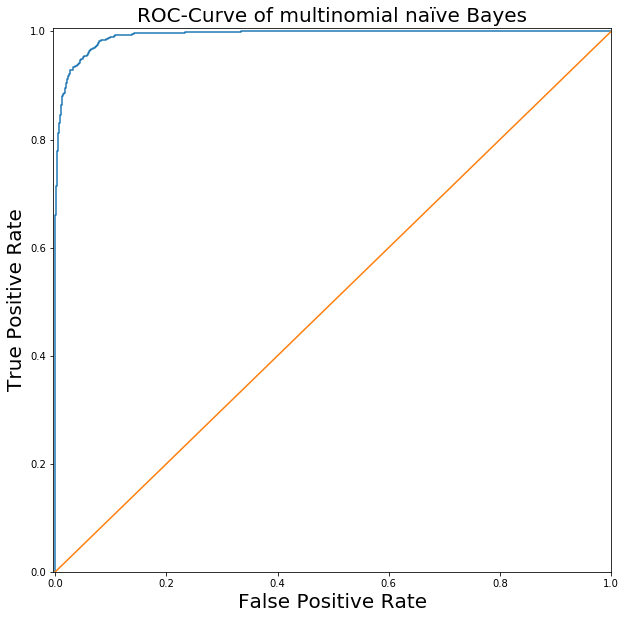

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
scaled_tfidf= min_max_scaler.fit_transform(transformed_tfidf)
scaled_test_tfidf = min_max_scaler.fit_transform(transformed_test_tfidf)

NB = MultinomialNB()
NB.fit(scaled_tfidf, train_targets)
NBprediction = NB.predict(scaled_test_tfidf)
NBaccuracy = np.mean(NBprediction == test_targets)
predict_probability = NB.predict_proba(scaled_test_tfidf[:])[:,1]

# Report results
print("Accuracy of multinomial naïve Bayes: " + str(NBaccuracy))
print("-"*60)
print("Classification report: ")
print(classification_report(test_targets, NBprediction, target_names=['Computer technology', 'Recreational activity']))
print("-"*60)
print("Confusion Matrix: ")
print(confusion_matrix(test_targets, NBprediction))
print("-"*60)

NBfpr, NBtpr, NBthreshold = roc_curve(test_targets, predict_probability)
line = [0, 1]
plt.figure(figsize=(10,10))
plt.plot(NBfpr, NBtpr)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 20)
plt.title('ROC-Curve of multinomial naïve Bayes', fontsize = 20)
plt.axis([-0.004, 1, 0, 1.006])
plt.show()

## Problem H

Repeat the same task with the logistic regression classifier, and plot the ROC curve for different
values of the threshold on class probabilities.

Accuracy of logistic regression classifier: 0.967301587302
------------------------------------------------------------
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.98      0.96      0.97      1560
Recreational activity       0.96      0.98      0.97      1590

          avg / total       0.97      0.97      0.97      3150

------------------------------------------------------------
Confusion Matrix: 
[[1490   70]
 [  33 1557]]
------------------------------------------------------------


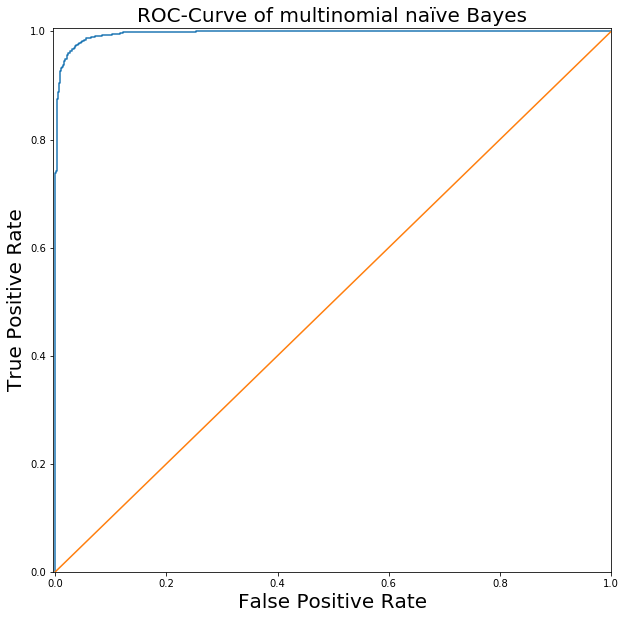

In [21]:
from sklearn.linear_model import LogisticRegression

logclassifier = LogisticRegression()
logclassifier.fit(transformed_tfidf, train_targets)
logprediction = logclassifier.predict(transformed_test_tfidf)
logaccuracy = np.mean(logprediction == test_targets)
logpredict_probability = logclassifier.predict_proba(transformed_test_tfidf[:])[:,1]

# Report results
print("Accuracy of logistic regression classifier: " + str(logaccuracy))
print("-"*60)
print("Classification report: ")
print(classification_report(test_targets, logprediction, target_names=['Computer technology', 'Recreational activity']))
print("-"*60)
print("Confusion Matrix: ")
print(confusion_matrix(test_targets, logprediction))
print("-"*60)

logfpr, logtpr, logthreshold = roc_curve(test_targets, logpredict_probability)
line = [0, 1]
plt.figure(figsize=(10,10))
plt.plot(logfpr,logtpr)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 20)
plt.title('ROC-Curve of multinomial naïve Bayes', fontsize = 20)
plt.axis([-0.004, 1, 0, 1.006])
plt.show()

## Problem I

Repeat part (h) by adding a regularization term to the optimization objective. Try both $l_1$ and $l_2$
norm regularizations and sweep through different regularization coefficients, ranging from very small
ones to large ones

$l_1$ norm regularizations 

In [22]:
c = [0.001,0.1,10,1000,1e5]

for c_value in c:
    log1 = LogisticRegression(C = c_value, penalty = 'l1')
    log1.fit(transformed_tfidf,train_targets)
    logpredict1 = log1.predict(transformed_test_tfidf)
    
    print("l1 Logistic regression: c = {}, accuracy = {}, coeff[0] = {:0.5f}".format(c_value, np.mean(logpredict1 == test_targets),log1.coef_[0][0]))
    print("Classification report: ")
    print(classification_report(test_targets, logpredict1, target_names=['Computer technology', 'Recreational activity']))
    print("Confusion Matrix: ")
    print(confusion_matrix(test_targets, logpredict1))
    print("="*60)

l1 Logistic regression: c = 0.001, accuracy = 0.49523809523809526, coeff[0] = 0.00000
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.50      1.00      0.66      1560
Recreational activity       0.00      0.00      0.00      1590

          avg / total       0.25      0.50      0.33      3150

Confusion Matrix: 
[[1560    0]
 [1590    0]]
l1 Logistic regression: c = 0.1, accuracy = 0.94, coeff[0] = 0.00000
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.95      0.92      0.94      1560
Recreational activity       0.93      0.96      0.94      1590

          avg / total       0.94      0.94      0.94      3150

Confusion Matrix: 
[[1442  118]
 [  71 1519]]
l1 Logistic regression: c = 10, accuracy = 0.9742857142857143, coeff[0] = -6.99654
Classification report: 
                       precision    recall  f1-score   support

  Computer technology   

C:\Users\sikas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


l1 Logistic regression: c = 1000, accuracy = 0.9761904761904762, coeff[0] = -8.77916
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.98      0.97      0.98      1560
Recreational activity       0.97      0.98      0.98      1590

          avg / total       0.98      0.98      0.98      3150

Confusion Matrix: 
[[1514   46]
 [  29 1561]]
l1 Logistic regression: c = 100000.0, accuracy = 0.9761904761904762, coeff[0] = -8.85635
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.98      0.97      0.98      1560
Recreational activity       0.97      0.98      0.98      1590

          avg / total       0.98      0.98      0.98      3150

Confusion Matrix: 
[[1514   46]
 [  29 1561]]


$l_2$ norm regularizations 

In [23]:
for c_value in c:
    log2 = LogisticRegression(C = c_value, penalty = 'l2')
    log2.fit(transformed_tfidf,train_targets)
    logpredict2 = log2.predict(transformed_test_tfidf)
    
    print("l2 Logistic regression: c = {}, accuracy = {}, coeff[0] = {:0.5f}".format(c_value, np.mean(logpredict2 == test_targets),log2.coef_[0][0]))
    print("Classification report: ")
    print(classification_report(test_targets, logpredict2, target_names=['Computer technology', 'Recreational activity']))
    print("Confusion Matrix: ")
    print(confusion_matrix(test_targets, logpredict2))
    print("="*60)

l2 Logistic regression: c = 0.001, accuracy = 0.7996825396825397, coeff[0] = -0.02271
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       1.00      0.60      0.75      1560
Recreational activity       0.72      1.00      0.83      1590

          avg / total       0.86      0.80      0.79      3150

Confusion Matrix: 
[[ 929  631]
 [   0 1590]]
l2 Logistic regression: c = 0.1, accuracy = 0.960952380952381, coeff[0] = -1.28118
Classification report: 
                       precision    recall  f1-score   support

  Computer technology       0.98      0.94      0.96      1560
Recreational activity       0.95      0.98      0.96      1590

          avg / total       0.96      0.96      0.96      3150

Confusion Matrix: 
[[1472   88]
 [  35 1555]]
l2 Logistic regression: c = 10, accuracy = 0.9733333333333334, coeff[0] = -4.92102
Classification report: 
                       precision    recall  f1-score   support

  Computer

## Multiclass Classification

Train classifiers on the documents belonging to the classes mentioned in part b;
namely

    comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, misc.forsale, soc.religion.christian.

Perform Naïve Bayes classification and multiclass SVM classification (with both One VS One and One VS
the rest methods described above) and report the confusion matrix and calculate the accuracy, recall
and precision of your classifiers.

**Preparing Data**

In [24]:
subcategories = ['comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','misc.forsale','soc.religion.christian']
subtrain = fetch_20newsgroups(subset='train', categories=subcategories, shuffle=True, random_state=42)
subtest = fetch_20newsgroups(subset='test', categories=subcategories, shuffle=True, random_state=42)

subtrain_counts = count_vect_final.fit_transform(subtrain.data)
tfidf_subtrain = tfidf_transformer.fit_transform(subtrain_counts)
transformed_subtfidf = trainNMF.fit_transform(tfidf_subtrain)

subtest_counts = count_vect_final.transform(subtest.data)#using the train CountVectorizer
tfidf_subtest = tfidf_transformer.transform(subtest_counts)#using the train TfidfTransformer
transformed_subtest_tfidf = trainNMF.transform(tfidf_subtest)#using the train TruncatedSVD

**Naïve Bayes classification**

In [25]:
subNB = MultinomialNB()
subNB.fit(transformed_subtfidf, subtrain.target)
subNBprediction = subNB.predict(transformed_subtest_tfidf)
subNBaccuracy = np.mean(subNBprediction == subtest.target)
# Report results
print("Accuracy of multinomial naïve Bayes: " + str(subNBaccuracy))
print("-"*60)
print("Classification report: ")
print(classification_report(subtest.target, subNBprediction, target_names=subcategories))
print("-"*60)
print("Confusion Matrix: ")
print(confusion_matrix(subtest.target, subNBprediction))

Accuracy of multinomial naïve Bayes: 0.854952076677
------------------------------------------------------------
Classification report: 
                          precision    recall  f1-score   support

comp.sys.ibm.pc.hardware       0.74      0.88      0.80       392
   comp.sys.mac.hardware       0.89      0.71      0.79       385
            misc.forsale       0.84      0.85      0.85       390
  soc.religion.christian       0.98      0.98      0.98       398

             avg / total       0.86      0.85      0.85      1565

------------------------------------------------------------
Confusion Matrix: 
[[343  24  23   2]
 [ 73 272  35   5]
 [ 46   9 333   2]
 [  3   0   5 390]]


**multiclass SVM classification（ One VS One ）**

In [26]:
from sklearn.multiclass import OneVsOneClassifier

m_classifier = svm.LinearSVC( C=1 ,dual=False, random_state=42)
ovoclassifier = OneVsOneClassifier(m_classifier)
ovoclassifier.fit(transformed_subtfidf, subtrain.target)

predict_ovo = ovoclassifier.predict(transformed_subtest_tfidf)
score_ovo = ovoclassifier.decision_function(transformed_subtest_tfidf)
accuracy_ovo = np.mean(predict_ovo == subtest.target)

# Report results
print("Accuracy of multiclass SVM classification(One Vs one): " + str(accuracy_ovo))
print("-"*60)
print("Classification report: ")
print(classification_report(subtest.target, predict_ovo, target_names=subcategories))
print("-"*60)
print("Confusion Matrix: ")
print(confusion_matrix(subtest.target, predict_ovo))

Accuracy of multiclass SVM classification(One Vs one): 0.860063897764
------------------------------------------------------------
Classification report: 
                          precision    recall  f1-score   support

comp.sys.ibm.pc.hardware       0.72      0.88      0.79       392
   comp.sys.mac.hardware       0.85      0.76      0.80       385
            misc.forsale       0.91      0.83      0.87       390
  soc.religion.christian       0.99      0.97      0.98       398

             avg / total       0.87      0.86      0.86      1565

------------------------------------------------------------
Confusion Matrix: 
[[344  36  12   0]
 [ 72 292  18   3]
 [ 54  13 322   1]
 [  7   1   2 388]]


**multiclass SVM classification（ One VS the rest）**

In [27]:
from sklearn.multiclass import OneVsRestClassifier

m_classifier = svm.LinearSVC( C=1 ,dual=False, random_state=42)
ovrclassifier = OneVsRestClassifier(m_classifier)
ovrclassifier.fit(transformed_subtfidf, subtrain.target)

predict_ovr = ovrclassifier.predict(transformed_subtest_tfidf)
score_ovr = ovrclassifier.decision_function(transformed_subtest_tfidf)
accuracy_ovr = np.mean(predict_ovr == subtest.target)

# Report results
print("Accuracy of multiclass SVM classification(One Vs one): " + str(accuracy_ovr))
print("-"*60)
print("Classification report: ")
print(classification_report(subtest.target, predict_ovr, target_names=subcategories))
print("-"*60)
print("Confusion Matrix: ")
print(confusion_matrix(subtest.target, predict_ovr))

Accuracy of multiclass SVM classification(One Vs one): 0.86517571885
------------------------------------------------------------
Classification report: 
                          precision    recall  f1-score   support

comp.sys.ibm.pc.hardware       0.76      0.86      0.80       392
   comp.sys.mac.hardware       0.87      0.77      0.81       385
            misc.forsale       0.88      0.84      0.86       390
  soc.religion.christian       0.97      0.99      0.98       398

             avg / total       0.87      0.87      0.87      1565

------------------------------------------------------------
Confusion Matrix: 
[[336  33  19   4]
 [ 61 296  23   5]
 [ 45  13 329   3]
 [  1   0   4 393]]
